# Multi-Method Microplastic Segmentation Comparison

**Comprehensive comparison of 3 segmentation architectures**

This notebook compares three state-of-the-art deep learning models for microplastic segmentation:

1. **U-Net** - Classic encoder-decoder with skip connections
2. **U-Net++** - Nested U-Net with dense skip pathways
3. **DeepLabV3+** - Atrous Spatial Pyramid Pooling (ASPP) for multi-scale features

## Dataset Information
- **Source**: Microplastics SEM Dataset (Mendeley)
- **Images**: 237 high-resolution SEM micrographs
- **Task**: Binary segmentation (microplastic vs background)
- **Dataset on Kaggle**: `micro-plastics-sem`
- **Path**: `/kaggle/input/micro-plastics-sem/dataset1/dataset1/micro-plastic-sem/`

## Comparison Metrics
- IoU (Intersection over Union)
- Dice Coefficient
- F1 Score
- Precision & Recall
- Training Time
- Model Size (Parameters)

## Expected Runtime
- ~45 minutes with GPU (15 min per model)
- 20 epochs per model

## 1. Setup and Installation

In [9]:
# # Stable Kaggle setup - Install compatible versions
# # IMPORTANT: Restart runtime after this cell to clear cached imports
# !pip uninstall -y numpy scipy scikit-learn -q
# !pip install -q --force-reinstall numpy==1.26.4
# !pip install -q --force-reinstall scikit-learn==1.5.2
# !pip install -q --force-reinstall scipy==1.11.4
# !pip install -q Pillow==10.3.0 tqdm==4.66.5 pyyaml==6.0.1 segmentation-models-pytorch==0.3.3 albumentations==1.4.3 opencv-python-headless==4.9.0.80 scikit-image==0.22.0 seaborn==0.13.2 matplotlib==3.8.0

# # Restart runtime to apply changes
# import os
# os.kill(os.getpid(), 9)

In [10]:
# Run this cell after runtime restarts
import torch, os, glob, time, warnings, cv2, numpy as np, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
from tqdm import tqdm
import torch.nn as nn, torch.optim as optim, torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score
warnings.filterwarnings('ignore')
print(f'PyTorch version: {torch.__version__}')
print(f'NumPy version: {np.__version__}')
print(f'SMP version: {smp.__version__}')
torch.manual_seed(42); np.random.seed(42)
if torch.cuda.is_available(): torch.cuda.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'\nUsing device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')

PyTorch version: 2.6.0+cu124
NumPy version: 1.26.4
SMP version: 0.3.3

Using device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 15.89 GB


## 2. Dataset Configuration

In [11]:
# Dataset paths for micro-plastics-sem on Kaggle
import os
import glob

print("Configuring Microplastics SEM dataset...")
print("="*70)

# Initialize paths
DATASET_PATH = None
IMAGE_DIR = None
MASK_DIR = None

# Check if running on Kaggle
if os.path.exists('/kaggle/input/'):
    # Kaggle environment
    base_path = '/kaggle/input/microplastics-sem-dataset/Microplastics_SEM'
    
    # Try different possible paths
    possible_paths = [
        f"{base_path}/dataset1/dataset1/micro-plastic-sem",
        f"{base_path}/micro-plastic-sem",
        f"{base_path}/dataset1/micro-plastic-sem",
        f"{base_path}",
    ]
    
    for path in possible_paths:
        if os.path.exists(f"{path}/image") and os.path.exists(f"{path}/label"):
            DATASET_PATH = path
            IMAGE_DIR = f"{path}/image"
            MASK_DIR = f"{path}/label"
            print(f"[OK] Found dataset at: {path}")
            break
    
    # Create output directories
    os.makedirs('/kaggle/working/models', exist_ok=True)
    os.makedirs('/kaggle/working/results', exist_ok=True)
else:
    # Local environment
    local_path = "C:/Users/SHIVAPREETHAM ROHITH/Desktop/AI/micro-plastic-detection/data/Microplastics_SEM/dataset1/dataset1/micro-plastic-sem"
    if os.path.exists(local_path):
        DATASET_PATH = local_path
        IMAGE_DIR = f"{local_path}/image"
        MASK_DIR = f"{local_path}/label"
        print(f"[OK] Using local dataset")
        os.makedirs('models', exist_ok=True)
        os.makedirs('results', exist_ok=True)

# Verify dataset
if DATASET_PATH is None:
    print("\n[ERROR] Could not find dataset!")
    print("Please ensure 'micro-plastics-sem' dataset is added to this notebook.")
    print("\nFor Kaggle: Add the 'micro-plastics-sem' dataset in the 'Add data' section.")
    print("For Local: Ensure dataset is at the local_path specified above.")
    raise FileNotFoundError("Dataset not found. Please check the paths and ensure the dataset is available.")
else:
    # Count files
    image_files = []
    mask_files = []
    for ext in ['*.png', '*.jpg', '*.tif', '*.PNG', '*.JPG', '*.TIF']:
        image_files.extend(glob.glob(os.path.join(IMAGE_DIR, ext)))
        mask_files.extend(glob.glob(os.path.join(MASK_DIR, ext)))
    
    print(f"\n[OK] Dataset path: {DATASET_PATH}")
    print(f"[OK] Images found: {len(image_files)}")
    print(f"[OK] Masks found: {len(mask_files)}")
    print("="*70)

Configuring Microplastics SEM dataset...
[OK] Found dataset at: /kaggle/input/microplastics-sem-dataset/Microplastics_SEM/dataset1/dataset1/micro-plastic-sem

[OK] Dataset path: /kaggle/input/microplastics-sem-dataset/Microplastics_SEM/dataset1/dataset1/micro-plastic-sem
[OK] Images found: 237
[OK] Masks found: 237


## 3. Dataset Class and Data Loading

In [12]:
class MicroplasticsDataset(Dataset):
    """Dataset class for Microplastics SEM images with segmentation masks"""
    
    def __init__(self, image_dir, mask_dir, transform=None, image_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_size = image_size
        
        # Find all images
        self.images = []
        for ext in ['*.png', '*.jpg', '*.tif', '*.PNG', '*.JPG', '*.TIF']:
            self.images.extend(glob.glob(os.path.join(image_dir, ext)))
        self.images = sorted(self.images)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.images[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load mask
        img_name = os.path.basename(img_path)
        mask_path = os.path.join(self.mask_dir, img_name)
        
        if not os.path.exists(mask_path):
            # Try different extension
            base_name = os.path.splitext(img_name)[0]
            for ext in ['.png', '.jpg', '.tif']:
                mask_path = os.path.join(self.mask_dir, base_name + ext)
                if os.path.exists(mask_path):
                    break
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype(np.float32)
        
        # Resize
        image = cv2.resize(image, self.image_size)
        mask = cv2.resize(mask, self.image_size, interpolation=cv2.INTER_NEAREST)
        
        # Apply transforms
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Ensure mask has channel dimension
        if len(mask.shape) == 2:
            mask = torch.FloatTensor(mask).unsqueeze(0)
        else:
            mask = mask.unsqueeze(0)
        
        return image, mask

# Data transforms
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Create dataset
full_dataset = MicroplasticsDataset(IMAGE_DIR, MASK_DIR, transform=train_transform)

# Split: 70% train, 20% val, 10% test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Apply validation transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

print(f"Dataset split:")
print(f"  Train: {len(train_dataset)} images")
print(f"  Val:   {len(val_dataset)} images")
print(f"  Test:  {len(test_dataset)} images")

# Data loaders
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

Dataset split:
  Train: 165 images
  Val:   47 images
  Test:  25 images


## 4. Model Architectures

### Method 1: U-Net
Classic encoder-decoder architecture with skip connections. Simple and effective baseline.

### Method 2: U-Net++
Nested U-Net with dense skip connections. Better feature propagation through multiple pathways.

### Method 3: DeepLabV3+
Uses Atrous Spatial Pyramid Pooling (ASPP) to capture multi-scale context. Excellent for objects of varying sizes.

In [13]:
def create_models():
    """Create all three segmentation models"""
    
    models = {}
    
    # Method 1: U-Net
    models['UNet'] = smp.Unet(
        encoder_name='resnet34',
        encoder_weights='imagenet',
        in_channels=3,
        classes=1,
        activation=None
    )
    
    # Method 2: U-Net++
    models['UNet++'] = smp.UnetPlusPlus(
        encoder_name='resnet34',
        encoder_weights='imagenet',
        in_channels=3,
        classes=1,
        activation=None
    )
    
    # Method 3: DeepLabV3+
    models['DeepLabV3+'] = smp.DeepLabV3Plus(
        encoder_name='resnet34',
        encoder_weights='imagenet',
        in_channels=3,
        classes=1,
        activation=None
    )
    
    # Print model information
    print("="*70)
    print("MODEL ARCHITECTURES")
    print("="*70)
    for name, model in models.items():
        params = sum(p.numel() for p in model.parameters())
        print(f"{name:15s} - Parameters: {params:,}")
    print("="*70)
    
    return models

# Create models
models = create_models()

MODEL ARCHITECTURES
UNet            - Parameters: 24,436,369
UNet++          - Parameters: 26,078,609
DeepLabV3+      - Parameters: 22,437,457


## 5. Loss Functions and Metrics

In [14]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        dice = (2 * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    
    def forward(self, pred, target):
        return self.alpha * self.bce(pred, target) + (1 - self.alpha) * self.dice(pred, target)

def calculate_metrics(pred, target, threshold=0.5):
    """Calculate comprehensive segmentation metrics"""
    pred_binary = (torch.sigmoid(pred) > threshold).float()
    pred_np = pred_binary.cpu().numpy().flatten().astype(int)
    target_np = target.cpu().numpy().flatten().astype(int)
    
    iou = jaccard_score(target_np, pred_np, zero_division=0)
    f1 = f1_score(target_np, pred_np, zero_division=0)
    precision = precision_score(target_np, pred_np, zero_division=0)
    recall = recall_score(target_np, pred_np, zero_division=0)
    
    intersection = (pred_binary * target).sum()
    dice = (2 * intersection) / (pred_binary.sum() + target.sum() + 1e-8)
    
    return {
        'iou': iou,
        'dice': dice.item(),
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## 6. Training Functions

In [15]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    metrics = {'iou': 0, 'dice': 0, 'f1': 0, 'precision': 0, 'recall': 0}
    
    for images, masks in tqdm(dataloader, desc="Training", leave=False):
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        batch_metrics = calculate_metrics(outputs, masks)
        for key in metrics:
            metrics[key] += batch_metrics[key]
    
    return total_loss / len(dataloader), {k: v / len(dataloader) for k, v in metrics.items()}

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    metrics = {'iou': 0, 'dice': 0, 'f1': 0, 'precision': 0, 'recall': 0}
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validation", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            total_loss += loss.item()
            batch_metrics = calculate_metrics(outputs, masks)
            for key in metrics:
                metrics[key] += batch_metrics[key]
    
    return total_loss / len(dataloader), {k: v / len(dataloader) for k, v in metrics.items()}

def train_model(model_name, model, train_loader, val_loader, num_epochs=20):
    """Train a single model and return results"""
    print(f"\n{'='*70}")
    print(f"TRAINING: {model_name}")
    print(f"{'='*70}")
    
    model = model.to(device)
    criterion = CombinedLoss(alpha=0.5)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    best_val_iou = 0
    history = {'train_loss': [], 'val_loss': [], 'train_metrics': [], 'val_metrics': []}
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        train_loss, train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_metrics = validate_epoch(model, val_loader, criterion, device)
        scheduler.step(val_loss)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_metrics'].append(train_metrics)
        history['val_metrics'].append(val_metrics)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}/{val_loss:.4f} - IoU: {val_metrics['iou']:.4f} - Dice: {val_metrics['dice']:.4f}")
        
        if val_metrics['iou'] > best_val_iou:
            best_val_iou = val_metrics['iou']
            save_path = f"/kaggle/working/models/best_{model_name}.pth" if os.path.exists('/kaggle/working/') else f"models/best_{model_name}.pth"
            torch.save(model.state_dict(), save_path)
    
    training_time = time.time() - start_time
    
    print(f"\n[OK] Training completed in {training_time:.2f}s")
    print(f"[OK] Best validation IoU: {best_val_iou:.4f}")
    
    return model, history, training_time

## 7. Train All Models

In [16]:
NUM_EPOCHS = 20
results = {}

print("\n" + "="*70)
print("TRAINING ALL MODELS")
print("="*70)
print(f"Epochs per model: {NUM_EPOCHS}")
print(f"Total models: {len(models)}")
print("="*70)

for model_name, model in models.items():
    trained_model, history, training_time = train_model(model_name, model, train_loader, val_loader, NUM_EPOCHS)
    results[model_name] = {
        'model': trained_model,
        'history': history,
        'training_time': training_time
    }

print("\n" + "="*70)
print("ALL MODELS TRAINED SUCCESSFULLY!")
print("="*70)


TRAINING ALL MODELS
Epochs per model: 20
Total models: 3

TRAINING: UNet


Epoch 1/20 - Loss: 0.6975/0.8267 - IoU: 0.2683 - Dice: 0.4206


Epoch 2/20 - Loss: 0.5653/0.6016 - IoU: 0.3807 - Dice: 0.5480


Epoch 3/20 - Loss: 0.5041/0.4801 - IoU: 0.5149 - Dice: 0.6758


Epoch 4/20 - Loss: 0.4681/0.4506 - IoU: 0.5825 - Dice: 0.7324


Epoch 5/20 - Loss: 0.4492/0.4412 - IoU: 0.6113 - Dice: 0.7551


Epoch 6/20 - Loss: 0.4239/0.4116 - IoU: 0.6596 - Dice: 0.7913


Epoch 7/20 - Loss: 0.4011/0.3927 - IoU: 0.6909 - Dice: 0.8142


Epoch 8/20 - Loss: 0.3817/0.3761 - IoU: 0.6952 - Dice: 0.8163


Epoch 9/20 - Loss: 0.3697/0.3713 - IoU: 0.6896 - Dice: 0.8121


Epoch 10/20 - Loss: 0.3534/0.3538 - IoU: 0.6964 - Dice: 0.8177


Epoch 11/20 - Loss: 0.3355/0.3401 - IoU: 0.7133 - Dice: 0.8295


Epoch 12/20 - Loss: 0.3100/0.3268 - IoU: 0.7227 - Dice: 0.8350


Epoch 13/20 - Loss: 0.2997/0.3056 - IoU: 0.7150 - Dice: 0.8297


Epoch 14/20 - Loss: 0.2838/0.2986 - IoU: 0.7276 - Dice: 0.8379


Epoch 15/20 - Loss: 0.2678/0.2816 - IoU: 0.7321 - Dice: 0.8408


Epoch 16/20 - Loss: 0.2475/0.2733 - IoU: 0.7389 - Dice: 0.8457


Epoch 17/20 - Loss: 0.2341/0.2512 - IoU: 0.7491 - Dice: 0.8529


Epoch 18/20 - Loss: 0.2198/0.2553 - IoU: 0.7356 - Dice: 0.8410


Epoch 19/20 - Loss: 0.2149/0.2501 - IoU: 0.7296 - Dice: 0.8371


Epoch 20/20 - Loss: 0.2069/0.2362 - IoU: 0.7418 - Dice: 0.8471

[OK] Training completed in 757.77s
[OK] Best validation IoU: 0.7491

TRAINING: UNet++


Epoch 1/20 - Loss: 0.6274/0.5955 - IoU: 0.3949 - Dice: 0.5634


Epoch 2/20 - Loss: 0.4765/0.4532 - IoU: 0.5979 - Dice: 0.7431


Epoch 3/20 - Loss: 0.4064/0.3966 - IoU: 0.6649 - Dice: 0.7930


Epoch 4/20 - Loss: 0.3750/0.3664 - IoU: 0.6847 - Dice: 0.8086


Epoch 5/20 - Loss: 0.3365/0.3406 - IoU: 0.6985 - Dice: 0.8161


Epoch 6/20 - Loss: 0.3075/0.3185 - IoU: 0.7178 - Dice: 0.8298


Epoch 7/20 - Loss: 0.2805/0.3076 - IoU: 0.7086 - Dice: 0.8226


Epoch 8/20 - Loss: 0.2620/0.2887 - IoU: 0.7252 - Dice: 0.8342


Epoch 9/20 - Loss: 0.2450/0.2710 - IoU: 0.7312 - Dice: 0.8408


Epoch 10/20 - Loss: 0.2255/0.2613 - IoU: 0.7245 - Dice: 0.8325


Epoch 11/20 - Loss: 0.2078/0.2495 - IoU: 0.7370 - Dice: 0.8428


Epoch 12/20 - Loss: 0.1965/0.2370 - IoU: 0.7446 - Dice: 0.8478


Epoch 13/20 - Loss: 0.1847/0.2223 - IoU: 0.7542 - Dice: 0.8557


Epoch 14/20 - Loss: 0.1736/0.2297 - IoU: 0.7256 - Dice: 0.8326


Epoch 15/20 - Loss: 0.1591/0.2185 - IoU: 0.7400 - Dice: 0.8442


Epoch 16/20 - Loss: 0.1538/0.2042 - IoU: 0.7564 - Dice: 0.8566


Epoch 17/20 - Loss: 0.1421/0.2149 - IoU: 0.7374 - Dice: 0.8392


Epoch 18/20 - Loss: 0.1358/0.2072 - IoU: 0.7351 - Dice: 0.8401


Epoch 19/20 - Loss: 0.1278/0.1971 - IoU: 0.7523 - Dice: 0.8514


Epoch 20/20 - Loss: 0.1227/0.1886 - IoU: 0.7560 - Dice: 0.8552

[OK] Training completed in 799.15s
[OK] Best validation IoU: 0.7564

TRAINING: DeepLabV3+


Epoch 1/20 - Loss: 0.7131/0.6760 - IoU: 0.3607 - Dice: 0.5252


Epoch 2/20 - Loss: 0.5497/0.5373 - IoU: 0.4806 - Dice: 0.6406


Epoch 3/20 - Loss: 0.4640/0.4389 - IoU: 0.5598 - Dice: 0.7128


Epoch 4/20 - Loss: 0.4134/0.3899 - IoU: 0.5931 - Dice: 0.7387


Epoch 5/20 - Loss: 0.3738/0.3590 - IoU: 0.6232 - Dice: 0.7644


Epoch 6/20 - Loss: 0.3491/0.3395 - IoU: 0.6347 - Dice: 0.7725


Epoch 7/20 - Loss: 0.3116/0.3043 - IoU: 0.6451 - Dice: 0.7800


Epoch 8/20 - Loss: 0.2837/0.2896 - IoU: 0.6435 - Dice: 0.7760


Epoch 9/20 - Loss: 0.2683/0.2806 - IoU: 0.6475 - Dice: 0.7786


Epoch 10/20 - Loss: 0.2566/0.2656 - IoU: 0.6540 - Dice: 0.7850


Epoch 11/20 - Loss: 0.2369/0.2499 - IoU: 0.6754 - Dice: 0.8020


Epoch 12/20 - Loss: 0.2219/0.2450 - IoU: 0.6761 - Dice: 0.8006


Epoch 13/20 - Loss: 0.2134/0.2380 - IoU: 0.6743 - Dice: 0.7991


Epoch 14/20 - Loss: 0.2005/0.2328 - IoU: 0.6787 - Dice: 0.8019


Epoch 15/20 - Loss: 0.1867/0.2281 - IoU: 0.6809 - Dice: 0.8022


Epoch 16/20 - Loss: 0.1863/0.2270 - IoU: 0.6860 - Dice: 0.8069


Epoch 17/20 - Loss: 0.1826/0.2296 - IoU: 0.6608 - Dice: 0.7856


Epoch 18/20 - Loss: 0.1770/0.2271 - IoU: 0.6667 - Dice: 0.7920


Epoch 19/20 - Loss: 0.1682/0.2218 - IoU: 0.6792 - Dice: 0.8022


Epoch 20/20 - Loss: 0.1586/0.2228 - IoU: 0.6586 - Dice: 0.7850

[OK] Training completed in 755.00s
[OK] Best validation IoU: 0.6860

ALL MODELS TRAINED SUCCESSFULLY!


## 8. Compare Results - Training Curves

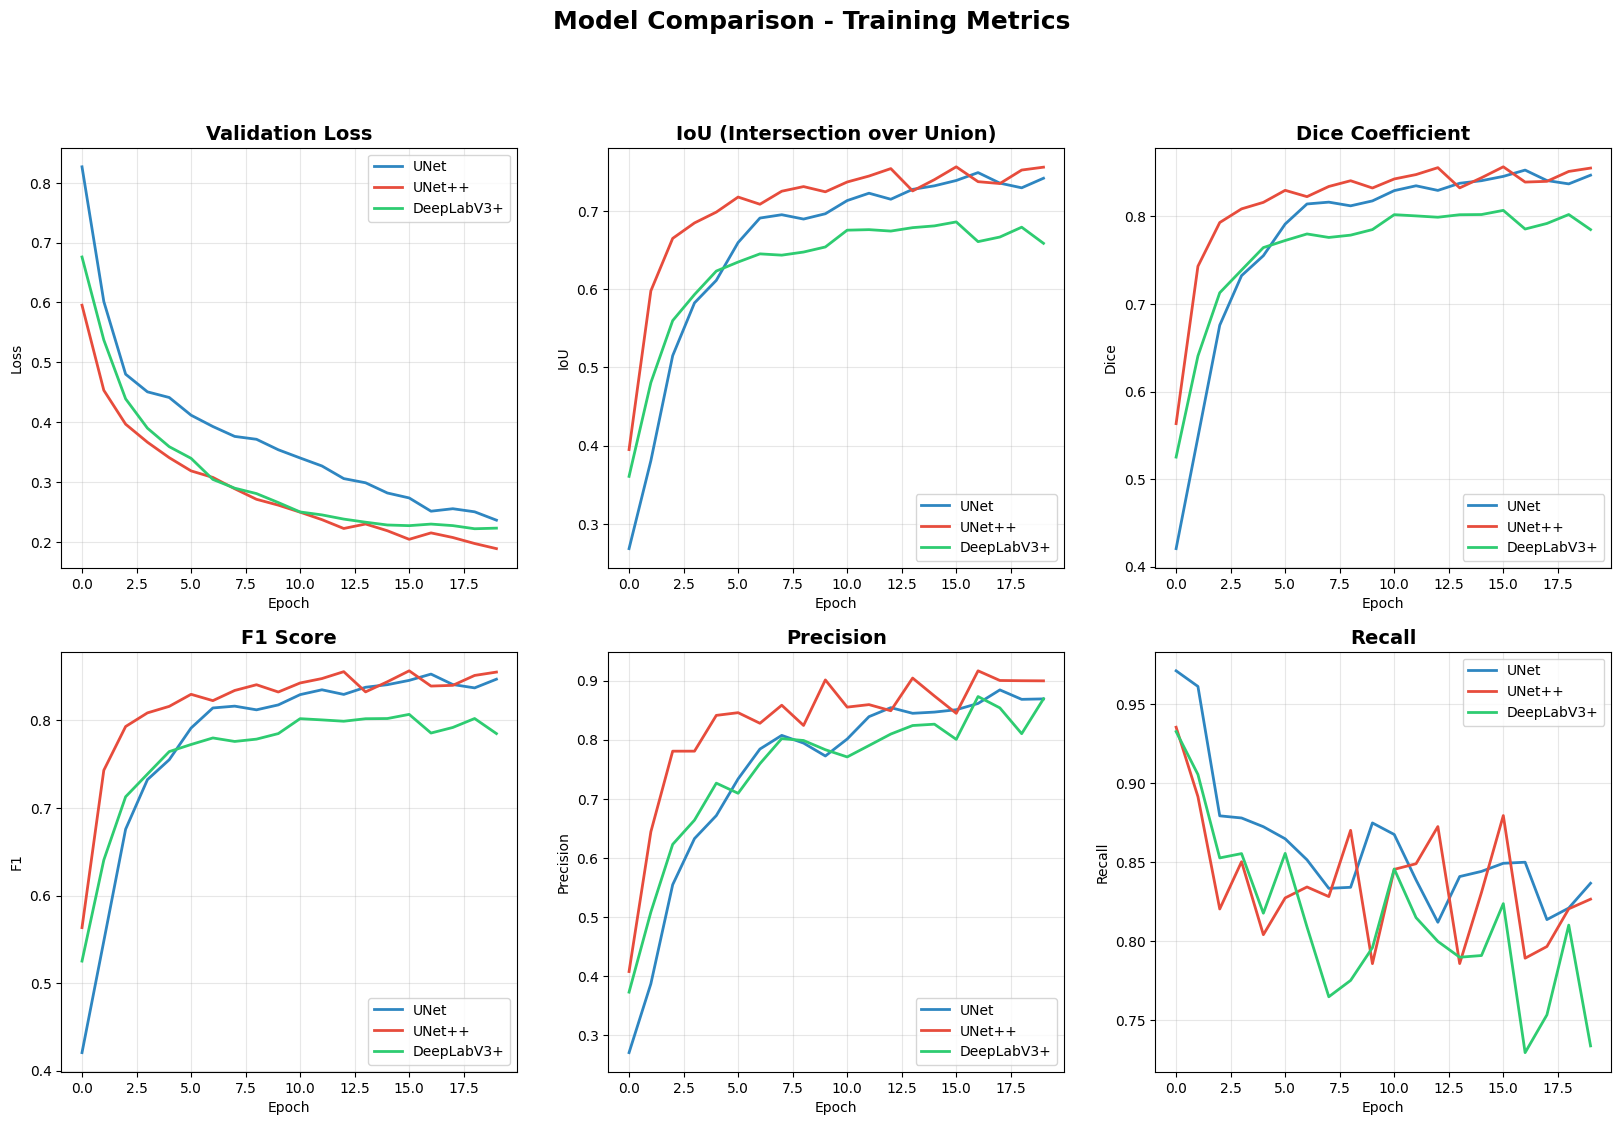

In [17]:
# Plot comparison of training curves
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
colors = {'UNet': '#2E86C1', 'UNet++': '#E74C3C', 'DeepLabV3+': '#2ECC71'}

# Loss
ax = axes[0, 0]
for model_name, data in results.items():
    ax.plot(data['history']['val_loss'], label=model_name, linewidth=2, color=colors[model_name])
ax.set_title('Validation Loss', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# IoU
ax = axes[0, 1]
for model_name, data in results.items():
    iou_values = [m['iou'] for m in data['history']['val_metrics']]
    ax.plot(iou_values, label=model_name, linewidth=2, color=colors[model_name])
ax.set_title('IoU (Intersection over Union)', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('IoU')
ax.legend()
ax.grid(True, alpha=0.3)

# Dice
ax = axes[0, 2]
for model_name, data in results.items():
    dice_values = [m['dice'] for m in data['history']['val_metrics']]
    ax.plot(dice_values, label=model_name, linewidth=2, color=colors[model_name])
ax.set_title('Dice Coefficient', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Dice')
ax.legend()
ax.grid(True, alpha=0.3)

# F1 Score
ax = axes[1, 0]
for model_name, data in results.items():
    f1_values = [m['f1'] for m in data['history']['val_metrics']]
    ax.plot(f1_values, label=model_name, linewidth=2, color=colors[model_name])
ax.set_title('F1 Score', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('F1')
ax.legend()
ax.grid(True, alpha=0.3)

# Precision
ax = axes[1, 1]
for model_name, data in results.items():
    prec_values = [m['precision'] for m in data['history']['val_metrics']]
    ax.plot(prec_values, label=model_name, linewidth=2, color=colors[model_name])
ax.set_title('Precision', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Precision')
ax.legend()
ax.grid(True, alpha=0.3)

# Recall
ax = axes[1, 2]
for model_name, data in results.items():
    recall_values = [m['recall'] for m in data['history']['val_metrics']]
    ax.plot(recall_values, label=model_name, linewidth=2, color=colors[model_name])
ax.set_title('Recall', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Recall')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Model Comparison - Training Metrics', fontsize=18, fontweight='bold', y=0.995)
save_path = '/kaggle/working/results/model_comparison_curves.png' if os.path.exists('/kaggle/working/') else 'results/model_comparison_curves.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

## 9. Final Test Evaluation

In [18]:
# Evaluate all models on test set
test_results = {}
criterion = CombinedLoss()

print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70)

for model_name, data in results.items():
    model = data['model']
    test_loss, test_metrics = validate_epoch(model, test_loader, criterion, device)
    test_results[model_name] = {
        'loss': test_loss,
        'metrics': test_metrics,
        'training_time': data['training_time'],
        'params': sum(p.numel() for p in model.parameters())
    }
    
    print(f"\n{model_name}:")
    print(f"  Loss: {test_loss:.4f}")
    print(f"  IoU: {test_metrics['iou']:.4f}")
    print(f"  Dice: {test_metrics['dice']:.4f}")
    print(f"  F1: {test_metrics['f1']:.4f}")
    print(f"  Precision: {test_metrics['precision']:.4f}")
    print(f"  Recall: {test_metrics['recall']:.4f}")
    print(f"  Training Time: {data['training_time']:.2f}s")


TEST SET EVALUATION



UNet:
  Loss: 0.1870
  IoU: 0.8007
  Dice: 0.8862
  F1: 0.8862
  Precision: 0.9050
  Recall: 0.8695
  Training Time: 757.77s



UNet++:
  Loss: 0.1471
  IoU: 0.8112
  Dice: 0.8925
  F1: 0.8925
  Precision: 0.9240
  Recall: 0.8649
  Training Time: 799.15s



DeepLabV3+:
  Loss: 0.1673
  IoU: 0.7436
  Dice: 0.8465
  F1: 0.8465
  Precision: 0.9150
  Recall: 0.7952
  Training Time: 755.00s


## 10. Comparison Table

In [19]:
# Create comparison dataframe
comparison_data = []
for model_name, data in test_results.items():
    comparison_data.append({
        'Model': model_name,
        'Parameters': f"{data['params']:,}",
        'Training Time (s)': f"{data['training_time']:.2f}",
        'Loss': f"{data['loss']:.4f}",
        'IoU': f"{data['metrics']['iou']:.4f}",
        'Dice': f"{data['metrics']['dice']:.4f}",
        'F1': f"{data['metrics']['f1']:.4f}",
        'Precision': f"{data['metrics']['precision']:.4f}",
        'Recall': f"{data['metrics']['recall']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("FINAL COMPARISON TABLE")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Save to CSV
save_path = '/kaggle/working/results/model_comparison.csv' if os.path.exists('/kaggle/working/') else 'results/model_comparison.csv'
comparison_df.to_csv(save_path, index=False)
print(f"\n[OK] Comparison table saved to: {save_path}")


FINAL COMPARISON TABLE
     Model Parameters Training Time (s)   Loss    IoU   Dice     F1 Precision Recall
      UNet 24,436,369            757.77 0.1870 0.8007 0.8862 0.8862    0.9050 0.8695
    UNet++ 26,078,609            799.15 0.1471 0.8112 0.8925 0.8925    0.9240 0.8649
DeepLabV3+ 22,437,457            755.00 0.1673 0.7436 0.8465 0.8465    0.9150 0.7952

[OK] Comparison table saved to: /kaggle/working/results/model_comparison.csv


## 11. Visual Comparison - Sample Predictions

Generating visual comparison...


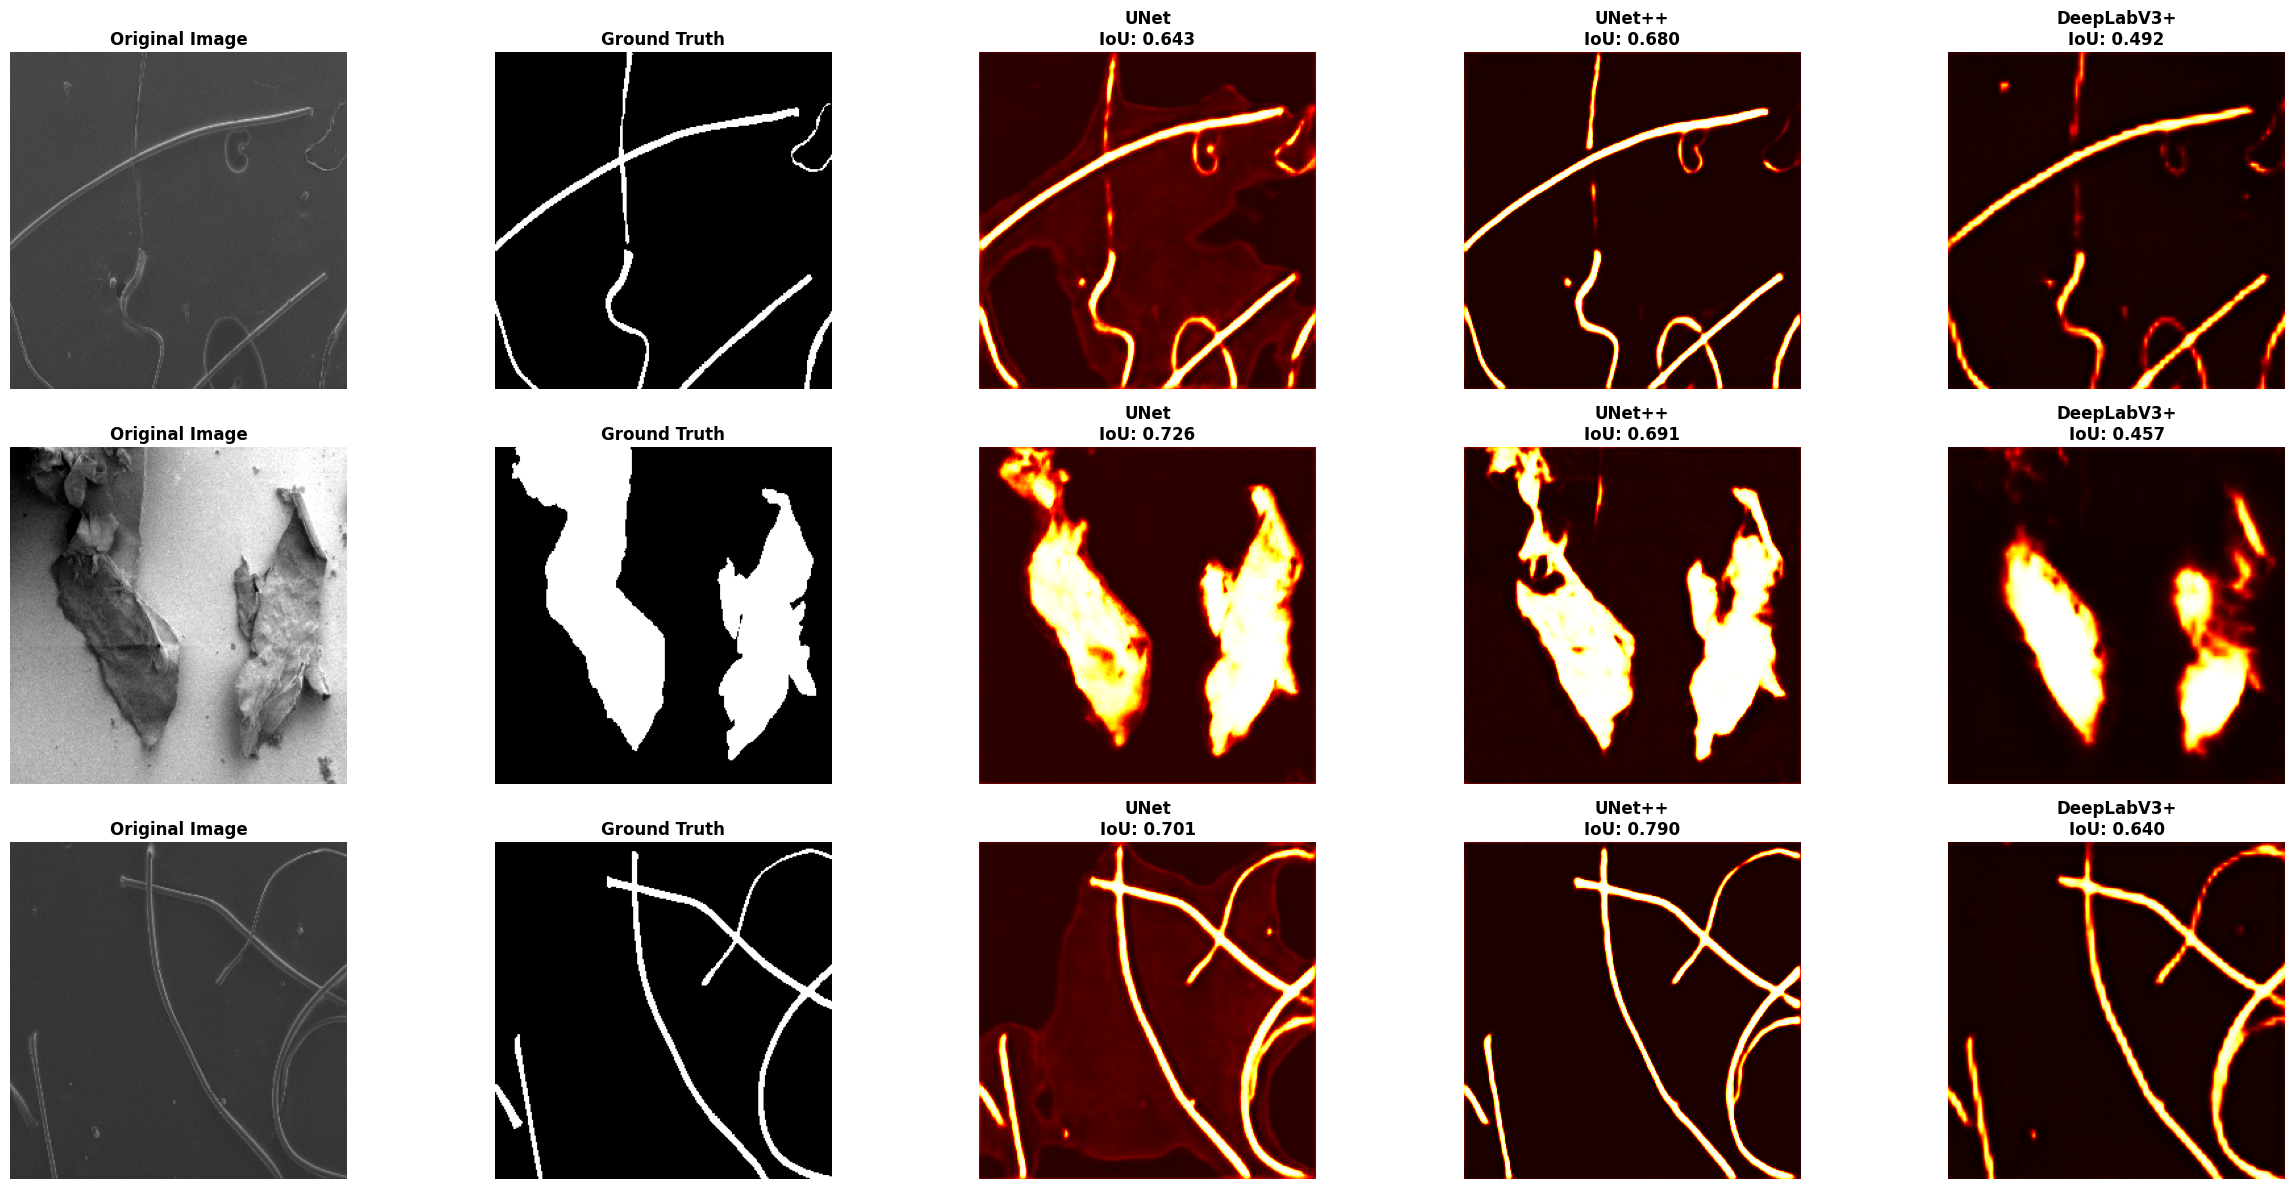

[OK] Predictions saved to: /kaggle/working/results/model_comparison_predictions.png


In [20]:
# Visualize predictions from all models on same images
def visualize_model_comparison(models_dict, dataloader, num_samples=3):
    fig, axes = plt.subplots(num_samples, len(models_dict) + 2, figsize=(25, num_samples * 4))
    
    data_iter = iter(dataloader)
    images, masks = next(data_iter)
    
    # Get predictions from all models
    predictions = {}
    for model_name, data in models_dict.items():
        model = data['model']
        model.eval()
        with torch.no_grad():
            outputs = model(images.to(device))
            preds = torch.sigmoid(outputs).cpu()
            predictions[model_name] = preds
    
    for i in range(min(num_samples, len(images))):
        # Denormalize image
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        mask_gt = masks[i].squeeze().numpy()
        
        # Original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image', fontsize=12, fontweight='bold')
        axes[i, 0].axis('off')
        
        # Ground truth
        axes[i, 1].imshow(mask_gt, cmap='gray')
        axes[i, 1].set_title('Ground Truth', fontsize=12, fontweight='bold')
        axes[i, 1].axis('off')
        
        # Model predictions
        for j, (model_name, pred) in enumerate(predictions.items()):
            pred_mask = pred[i].squeeze().numpy()
            iou = jaccard_score(mask_gt.flatten(), (pred_mask > 0.5).astype(int).flatten(), zero_division=0)
            
            axes[i, j + 2].imshow(pred_mask, cmap='hot', vmin=0, vmax=1)
            axes[i, j + 2].set_title(f'{model_name}\nIoU: {iou:.3f}', fontsize=12, fontweight='bold')
            axes[i, j + 2].axis('off')
    
    plt.tight_layout()
    save_path = '/kaggle/working/results/model_comparison_predictions.png' if os.path.exists('/kaggle/working/') else 'results/model_comparison_predictions.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"[OK] Predictions saved to: {save_path}")

print("Generating visual comparison...")
visualize_model_comparison(results, test_loader, num_samples=3)

## 12. Summary and Recommendations

This section will automatically determine the best model based on test results.

In [21]:
# Find best model
best_model = max(test_results.items(), key=lambda x: x[1]['metrics']['iou'])
best_name = best_model[0]
best_metrics = best_model[1]

print("\n" + "="*70)
print("SUMMARY AND RECOMMENDATIONS")
print("="*70)
print(f"\nBest Model: {best_name}")
print(f"  IoU: {best_metrics['metrics']['iou']:.4f}")
print(f"  Dice: {best_metrics['metrics']['dice']:.4f}")
print(f"  F1 Score: {best_metrics['metrics']['f1']:.4f}")
print(f"  Training Time: {best_metrics['training_time']:.2f}s")

print("\nModel Characteristics:")
for model_name in ['UNet', 'UNet++', 'DeepLabV3+']:
    if model_name == 'UNet':
        print("  - U-Net: Fast, simple, good baseline")
    elif model_name == 'UNet++':
        print("  - U-Net++: Better feature propagation, slightly slower")
    elif model_name == 'DeepLabV3+':
        print("  - DeepLabV3+: Multi-scale features, best for varying object sizes")

print("\nRecommendation:")
print(f"  Use {best_name} for production deployment.")
print(f"  It achieved the best IoU score of {best_metrics['metrics']['iou']:.4f}")

print("\n" + "="*70)
print("OUTPUTS SAVED:")
print("="*70)
base_path = '/kaggle/working/' if os.path.exists('/kaggle/working/') else ''
print(f"  - Models: {base_path}models/best_*.pth")
print(f"  - Comparison table: {base_path}results/model_comparison.csv")
print(f"  - Training curves: {base_path}results/model_comparison_curves.png")
print(f"  - Predictions: {base_path}results/model_comparison_predictions.png")
print("="*70)


SUMMARY AND RECOMMENDATIONS

Best Model: UNet++
  IoU: 0.8112
  Dice: 0.8925
  F1 Score: 0.8925
  Training Time: 799.15s

Model Characteristics:
  - U-Net: Fast, simple, good baseline
  - U-Net++: Better feature propagation, slightly slower
  - DeepLabV3+: Multi-scale features, best for varying object sizes

Recommendation:
  Use UNet++ for production deployment.
  It achieved the best IoU score of 0.8112

OUTPUTS SAVED:
  - Models: /kaggle/working/models/best_*.pth
  - Comparison table: /kaggle/working/results/model_comparison.csv
  - Training curves: /kaggle/working/results/model_comparison_curves.png
  - Predictions: /kaggle/working/results/model_comparison_predictions.png
